In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl

### Function to parse through *differential expression* CSV files and returns:
1. Gene Symbols
1. log2FC
1.  B-H adjusted p-value for different microarray platforms

For each microarray experiment - iterate through each row (e.g. probe), find corresponding gene symbol (if one exists) and return corresponding log2FC & adjusted p-val

In [2]:
def extract_gene_logFC_pval_from_diff_exp_csv(microarray_diff_exp_data_filepath_i):
    
    '''
    input: path to differential expression CSV file
    '''

    diff_exp_data_df = pd.read_csv(microarray_diff_exp_data_filepath_i) #load dataframe from csv file

    gene_symbols_list_microarray_i = [] 
    logFC_list_microarray_i = []
    pval_list_microarray_i = []

    microarray_platform = microarray_platform_dict[microarray_diff_exp_data_filepath_i.split('/')[-1].split('.')[0]]

    if (microarray_platform == 'GPL6947') or (microarray_platform == 'GPL4133') or (microarray_platform == 'GPL10558') or (microarray_platform == 'GPL570') or (microarray_platform == 'GPL11532') or (microarray_platform == 'GPL6102') or (microarray_platform == 'GPL6480') or (microarray_platform == 'GPL6883'):
                
        diff_exp_data_df = diff_exp_data_df.loc[: , ['Gene.symbol' , 'logFC' , 'adj.P.Val']] #subset to relevant columns

        for row_i in diff_exp_data_df.index:

            gene_symbol_i , logFC_i , pval_i = diff_exp_data_df.loc[row_i , :]

            #multiple genes, store logFC & pval for each gene
            if (type(gene_symbol_i) == str) and ('///' in gene_symbol_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                for gene_symbol_i in list(set([gene for gene in gene_symbol_i.split('///')])):                                
                    gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                    logFC_list_microarray_i.append(logFC_i)
                    pval_list_microarray_i.append(pval_i)

            #one gene, if gene symbol exists, and logFC/pval exist, store data
            elif (type(gene_symbol_i) == str) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                logFC_list_microarray_i.append(logFC_i)
                pval_list_microarray_i.append(pval_i)
                
    elif (microarray_platform == 'GPL5175'):

        diff_exp_data_df = diff_exp_data_df.loc[: , ['gene_assignment' , 'logFC' , 'adj.P.Val']]

        for row_i in diff_exp_data_df.index:

            gene_assignment_i , logFC_i , pval_i = diff_exp_data_df.loc[row_i , :]

            #multiple genes, store logFC & pval for each gene
            if (type(gene_assignment_i) == str) and ('///' in gene_assignment_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                for gene_symbol_i in list(set([gene_info.split('//')[1] for gene_info in gene_assignment_i.split('///')])):                                
                    gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                    logFC_list_microarray_i.append(logFC_i)
                    pval_list_microarray_i.append(pval_i)

            #one gene
            elif (type(gene_assignment_i) == str) and ('//' in gene_assignment_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                gene_symbol_i = gene_assignment_i.split('//')[1]
                gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                logFC_list_microarray_i.append(logFC_i)
                pval_list_microarray_i.append(pval_i)

    elif (microarray_platform == 'GPL16951'):

        diff_exp_data_df = diff_exp_data_df.loc[: , ['Gene_symbol' , 'logFC' , 'adj.P.Val']]

        for row_i in diff_exp_data_df.index:

            gene_symbol_i , logFC_i , pval_i = diff_exp_data_df.loc[row_i , :]

            #multiple genes
            if (gene_symbol_i != 'previous version conserved probe') and (type(gene_symbol_i) == str) and ('|' in gene_symbol_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                for gene_symbol_i in list(set([gene for gene in gene_symbol_i.split('|')])):                                
                    gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                    logFC_list_microarray_i.append(logFC_i)
                    pval_list_microarray_i.append(pval_i)

            #one gene
            elif (gene_symbol_i != 'previous version conserved probe') and (type(gene_symbol_i) == str) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                logFC_list_microarray_i.append(logFC_i)
                pval_list_microarray_i.append(pval_i)

    gene_logFC_pval_df = pd.DataFrame()
    gene_logFC_pval_df['gene'] = gene_symbols_list_microarray_i
    gene_logFC_pval_df['logFC'] = logFC_list_microarray_i
    gene_logFC_pval_df['pval'] = pval_list_microarray_i
    
    #set index to gene symbol
    gene_logFC_pval_df.set_index('gene' , inplace = True , drop = True)

    return gene_logFC_pval_df

### Function to parse through *processed differential expression* dataframes (gene symbols-logFC-pval) and return series with genes & logFC that have:

1. $|\log_2(FC)| > \log_2(1.5)$
1. $\text{BH adjusted pval} \le 0.05$
1. If a gene has multiple rows (e.g. probes) that fit criteria for (1) and (2), report mean $\log_2(FC)$ for all rows with $\text{BH adj. pval} \le 0.05$

In [3]:
#set thresholds for logFC & pval
logFC_thresh = np.log2(1.5)
pval_thresh = 0.05

In [4]:
def extract_significant_gene_logFC(gene_logFC_pval_df, analysis_ID):

    #get dictionary that counts the instances of each gene in this data (most will coorespond to 1 row)
    num_rows_per_gene_dict = Counter(gene_logFC_pval_df.index) #keys:unique genes, values:number of rows w/ logFC
    logFC_series = pd.Series(index = list(num_rows_per_gene_dict.keys()), name = analysis_ID) #empty series that stores logFC or NaN for each gene

    #iterate through each gene, check if logFC & pval pass thresholds
    for gene_i in logFC_series.index:

        #one logFC measurement for gene
        if num_rows_per_gene_dict[gene_i] == 1:

            logFC_i , pval_i = gene_logFC_pval_df.loc[gene_i , :]

            if (abs(logFC_i) > logFC_thresh) and (pval_i <= pval_thresh): #gene exp measurement meets thresholds
                logFC_series[gene_i] = logFC_i
            else:
                logFC_series[gene_i] = 0.0

        #multiple logFC measurements for gene
        elif num_rows_per_gene_dict[gene_i] > 1:

            valid_logFC_meas = [] #list of valid logFC measurements that meet thresholds
            for logFC_i , pval_i in zip(gene_logFC_pval_df.loc[gene_i , 'logFC'], gene_logFC_pval_df.loc[gene_i , 'pval']):

                if (abs(logFC_i) > logFC_thresh) and (pval_i <= pval_thresh):
                    valid_logFC_meas.append(logFC_i)

            if len(valid_logFC_meas) == 1: #one valid logFC measurement
                logFC_series[gene_i] = valid_logFC_meas[0]
            elif len(valid_logFC_meas) > 1: #multiple valid logFC measurements
                logFC_series[gene_i] = np.mean(valid_logFC_meas)
            elif len(valid_logFC_meas) == 0:
                logFC_series[gene_i] = 0.0
                
    return logFC_series

# ATB vs LTBI 

### Directory where the Differential Gene Expression Data is stored

In [5]:
microarray_diff_exp_data = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Microarray Differential Gene Expression/ATB_v_LTBI/"

#seperate differential gene expression files from different studies
microarray_diff_exp_data_files = [
'GSE19439.csv', 
'GSE19442.csv', 
'GSE19444.csv', 
'GSE28623.csv', 
'GSE37250.csv', 
'GSE39939.csv', 
'GSE39940.csv', 
'GSE41055.csv', 
'GSE54992.csv', 
'GSE62525.csv', 
'GSE69581.csv', 
'GSE73408.csv']

Mapping of microarray platform used for each study

In [6]:
microarray_platform_dict = {
'GSE19439':'GPL6947',
'GSE19442':'GPL6947',
'GSE19444':'GPL6947',
'GSE28623':'GPL4133',
'GSE37250':'GPL10558',
'GSE39939':'GPL10558',
'GSE39940':'GPL10558',
'GSE41055':'GPL5175',
'GSE54992':'GPL570',
'GSE62525':'GPL16951',
'GSE69581':'GPL10558',
'GSE73408':'GPL11532'}

### Extract significant logFC measurements from each differential gene expression analysis

In [7]:
#construct a dictionary to hold the logFC series for each analysis
sig_gene_logFC_per_experiment_dict = {}

for microarray_diff_exp_data_file_i in microarray_diff_exp_data_files:
    
    analysis_ID = microarray_diff_exp_data_file_i.split('.')[0]
    print('processing file {0}'.format(analysis_ID))

    #get logFC & pvals for all genes (and all probes) from diff gene exp experiment
    gene_logFC_pval_df = extract_gene_logFC_pval_from_diff_exp_csv(microarray_diff_exp_data + microarray_diff_exp_data_file_i)

    #filter for significant genes (with logFC > logFC_thresh, pval >= pval_thresh, ensure 1 gene measurement per analysis/experiment)
    logFC_series = extract_significant_gene_logFC(gene_logFC_pval_df, analysis_ID)
    
    #store significant logFC per gene in dict
    sig_gene_logFC_per_experiment_dict[analysis_ID] = logFC_series

processing file GSE19439


//anaconda3/envs/py37_and_R_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


processing file GSE19442
processing file GSE19444
processing file GSE28623
processing file GSE37250
processing file GSE39939
processing file GSE39940
processing file GSE41055
processing file GSE54992
processing file GSE62525
processing file GSE69581
processing file GSE73408


### Create DataFrame to store all of the significant logFC changes across all analyses

In [8]:
#construct a set of non-redundant genes across all studies for index of DataFrame
unique_genes = set([])
for analysis_ID in sig_gene_logFC_per_experiment_dict.keys():
    
    gene_set_i = set(sig_gene_logFC_per_experiment_dict[analysis_ID].index) #genes analyzed in experiment
    unique_genes = unique_genes.union(gene_set_i) #append to set of genes
    
unique_genes = list(unique_genes) #convert to list

#create DataFrame with zeros
ATB_v_LTBI_diff_gene_exp_df = pd.DataFrame(index = unique_genes)

#iterate over logFC series from each differential gene expression analysis and fill DataFrame
for analysis_ID in sig_gene_logFC_per_experiment_dict.keys():
    
    #merge the series holding the logFC values from a specific dataset to the master dataframe with the significant logFC values from all datasets
    ATB_v_LTBI_diff_gene_exp_df = ATB_v_LTBI_diff_gene_exp_df.join(sig_gene_logFC_per_experiment_dict[analysis_ID])
    
#fill any NaN values in the DataFrame with zeros (some microarray platforms may not have probes for specific genes)
ATB_v_LTBI_diff_gene_exp_df.fillna(0.0 , inplace = True)

In [9]:
ATB_v_LTBI_diff_gene_exp_df

,GSE19439,GSE19442,GSE19444,GSE28623,GSE37250,GSE39939,GSE39940,GSE41055,GSE54992,GSE62525,GSE69581,GSE73408
CFAP157,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
CECR2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
EPB49,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
ODF2L,-0.678457,-0.806830,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
PTCSC2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
PPP1R16A,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
CCNA1,0.000000,0.000000,0.0,0.0,0.0,0.0,2.899543,0.0,0.0,0.000000,0.000000,0.0
PYDC1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
SGK1,0.000000,-0.720386,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.738174,-0.646754,0.0


#### Output DataFrame as a CSV

In [10]:
ATB_v_LTBI_diff_gene_exp_df.to_csv(microarray_diff_exp_data + 'signif_logFC_across_studies.csv')

#### Across how many datasets was each gene *significantly* differentially expressed in?

In [11]:
num_datasets_diff_exp_per_gene = pd.Series(index = ATB_v_LTBI_diff_gene_exp_df.index)

#iterate through each gene
for gene_i in num_datasets_diff_exp_per_gene.index:
    
    #boolean filter for specific gene that is TRUE is gene was significantly differentially expressed in study & FALSE otherwise
    num_datasets_diff_exp_per_gene[gene_i] = np.sum(ATB_v_LTBI_diff_gene_exp_df.loc[gene_i , :] != 0.0)

//anaconda3/envs/py37_and_R_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [12]:
num_datasets_diff_exp_per_gene.sort_values(ascending = False).head(n = 5)

CCR7      11.0
EPHA4     11.0
ADM       11.0
EPSTI1    11.0
TDRD9     11.0
dtype: float64

In [13]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

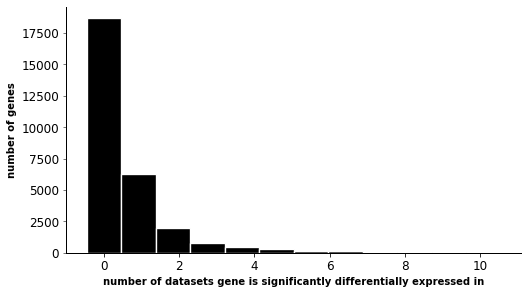

In [14]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(num_datasets_diff_exp_per_gene , bins = 12 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.35 , align = 'left')

plt.xlabel('number of datasets gene is significantly differentially expressed in', fontweight = 'bold' , fontsize = 10, color = 'k')
plt.ylabel('number of genes', fontweight = 'bold' , fontsize = 10, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 4.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

How many genes were found to be significantly differentially expressed in at least 7 datasets?

In [19]:
len(num_datasets_diff_exp_per_gene[num_datasets_diff_exp_per_gene >= 7])

391

Which genes were they? Plug this gene set into **enrichr**

In [ ]:
for gene in num_datasets_diff_exp_per_gene[num_datasets_diff_exp_per_gene >= 7].index:
    print(gene)

Results from plugging in 391 genes into https://amp.pharm.mssm.edu/Enrichr/

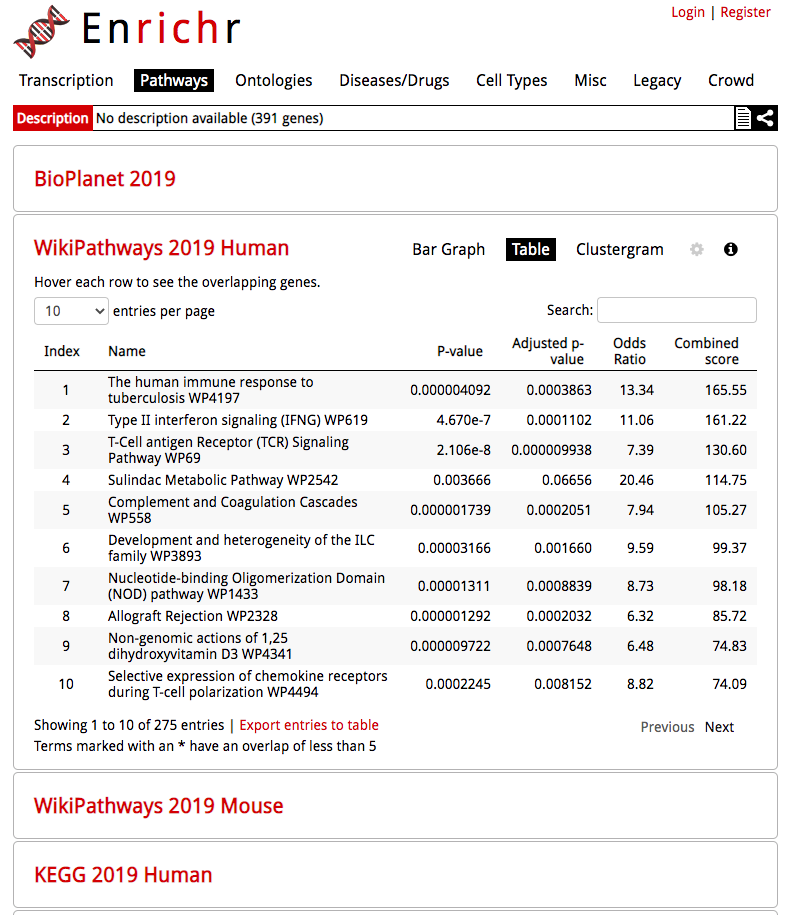

In [21]:
from IPython.display import Image
Image(filename = microarray_diff_exp_data + "enrichr_results_391_genes.png", width=600, height=900)

# ATB vs HC

### Directory where the Differential Gene Expression Data is stored

In [22]:
microarray_diff_exp_data = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Microarray Differential Gene Expression/ATB_v_HC/"

#seperate differential gene expression files from different studies
microarray_diff_exp_data_files = [
'GSE19439.csv', 
'GSE19444.csv', 
'GSE28623.csv', 
'GSE29536.csv', 
'GSE34608.csv', 
'GSE41055.csv', 
'GSE42825.csv', 
'GSE42826.csv', 
'GSE42830.csv', 
'GSE56153.csv', 
'GSE54992.csv',
'GSE62525.csv',
'GSE73408.csv',
'GSE83456.csv']

Mapping of microarray platform used for each study

In [23]:
microarray_platform_dict = {
'GSE19439':'GPL6947',
'GSE19444':'GPL6947',
'GSE28623':'GPL4133',
'GSE29536':'GPL6102',
'GSE34608':'GPL6480',
'GSE41055':'GPL5175',
'GSE42825':'GPL10558',
'GSE42826':'GPL10558',
'GSE42830':'GPL10558',
'GSE56153':'GPL6883',
'GSE54992':'GPL570',
'GSE62525':'GPL16951',
'GSE73408':'GPL11532',
'GSE83456':'GPL10558'}

### Extract significant logFC measurements from each differential gene expression analysis

In [24]:
#construct a dictionary to hold the logFC series for each analysis
sig_gene_logFC_per_experiment_dict = {}

for microarray_diff_exp_data_file_i in microarray_diff_exp_data_files:
    
    analysis_ID = microarray_diff_exp_data_file_i.split('.')[0]
    print('processing file {0}'.format(analysis_ID))

    #get logFC & pvals for all genes (and all probes) from diff gene exp experiment
    gene_logFC_pval_df = extract_gene_logFC_pval_from_diff_exp_csv(microarray_diff_exp_data + microarray_diff_exp_data_file_i)

    #filter for significant genes (with logFC > logFC_thresh, pval >= pval_thresh, ensure 1 gene measurement per analysis/experiment)
    logFC_series = extract_significant_gene_logFC(gene_logFC_pval_df, analysis_ID)
    
    #store significant logFC per gene in dict
    sig_gene_logFC_per_experiment_dict[analysis_ID] = logFC_series

processing file GSE19439


//anaconda3/envs/py37_and_R_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


processing file GSE19444
processing file GSE28623
processing file GSE29536
processing file GSE34608
processing file GSE41055
processing file GSE42825
processing file GSE42826
processing file GSE42830
processing file GSE56153
processing file GSE54992
processing file GSE62525
processing file GSE73408
processing file GSE83456


### Create DataFrame to store all of the significant logFC changes across all analyses

In [25]:
#construct a set of non-redundant genes across all studies for index of DataFrame
unique_genes = set([])
for analysis_ID in sig_gene_logFC_per_experiment_dict.keys():
    
    gene_set_i = set(sig_gene_logFC_per_experiment_dict[analysis_ID].index) #genes analyzed in experiment
    unique_genes = unique_genes.union(gene_set_i) #append to set of genes
    
unique_genes = list(unique_genes) #convert to list

#create DataFrame with zeros
ATB_v_HC_diff_gene_exp_df = pd.DataFrame(index = unique_genes)

#iterate over logFC series from each differential gene expression analysis and fill DataFrame
for analysis_ID in sig_gene_logFC_per_experiment_dict.keys():
    
    #merge the series holding the logFC values from a specific dataset to the master dataframe with the significant logFC values from all datasets
    ATB_v_HC_diff_gene_exp_df = ATB_v_HC_diff_gene_exp_df.join(sig_gene_logFC_per_experiment_dict[analysis_ID])
    
#fill any NaN values in the DataFrame with zeros (some microarray platforms may not have probes for specific genes)
ATB_v_HC_diff_gene_exp_df.fillna(0.0 , inplace = True)

In [26]:
ATB_v_HC_diff_gene_exp_df

,GSE19439,GSE19444,GSE28623,GSE29536,GSE34608,GSE41055,GSE42825,GSE42826,GSE42830,GSE56153,GSE54992,GSE62525,GSE73408,GSE83456
CFAP157,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
CECR2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
EPB49,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
ODF2L,0.000000,0.0,0.0,0.000000,0.705580,0.0,0.0,0.0,0.0,0.000000,0.0,-0.745277,0.000000,0.0
PTCSC2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PPP1R16A,0.000000,0.0,0.0,0.000000,-1.728026,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
CCNA1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-1.054629,0.0
PYDC1,0.000000,0.0,0.0,0.000000,-0.839445,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
SGK1,-0.761461,0.0,0.0,-1.238751,0.688138,0.0,0.0,0.0,0.0,-1.159362,0.0,0.000000,0.000000,0.0


#### Output DataFrame as a CSV

In [27]:
ATB_v_HC_diff_gene_exp_df.to_csv(microarray_diff_exp_data + 'signif_logFC_across_studies.csv')

#### Across how many datasets was each gene *significantly* differentially expressed in?

In [28]:
num_datasets_diff_exp_per_gene = pd.Series(index = ATB_v_HC_diff_gene_exp_df.index)

#iterate through each gene
for gene_i in num_datasets_diff_exp_per_gene.index:
    
    #boolean filter for specific gene that is TRUE is gene was significantly differentially expressed in study & FALSE otherwise
    num_datasets_diff_exp_per_gene[gene_i] = np.sum(ATB_v_HC_diff_gene_exp_df.loc[gene_i , :] != 0.0)

//anaconda3/envs/py37_and_R_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [29]:
num_datasets_diff_exp_per_gene.sort_values(ascending = False).head(n = 5)

BATF2    13.0
DYSF     13.0
GBP5     13.0
CASP5    12.0
ADM      12.0
dtype: float64

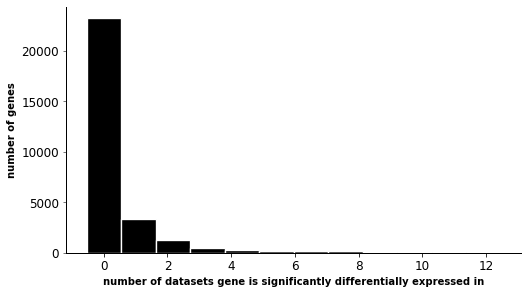

In [30]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(num_datasets_diff_exp_per_gene , bins = 12 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.35 , align = 'left')

plt.xlabel('number of datasets gene is significantly differentially expressed in', fontweight = 'bold' , fontsize = 10, color = 'k')
plt.ylabel('number of genes', fontweight = 'bold' , fontsize = 10, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 4.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

How many genes were found to be significantly differentially expressed in at least 7 datasets?

In [31]:
len(num_datasets_diff_exp_per_gene[num_datasets_diff_exp_per_gene >= 7])

496

Which genes were they? Plug this gene set into **enrichr**

In [ ]:
for gene in num_datasets_diff_exp_per_gene[num_datasets_diff_exp_per_gene >= 7].index:
    print(gene)

Results from plugging in 496 genes into https://amp.pharm.mssm.edu/Enrichr/

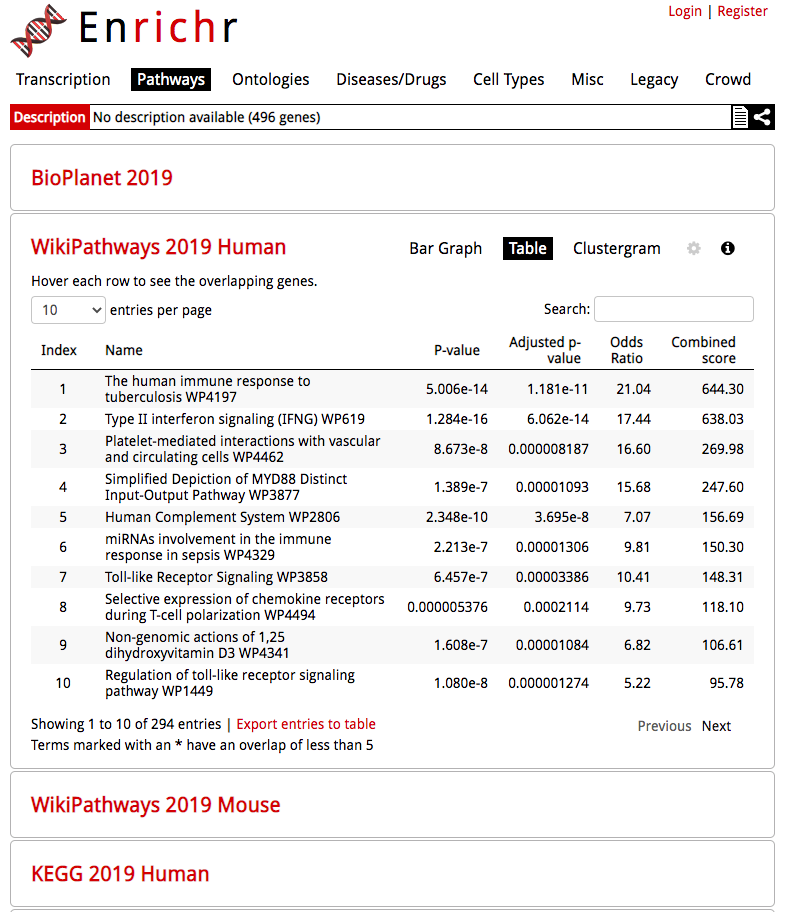

In [34]:
from IPython.display import Image
Image(filename = microarray_diff_exp_data + "enrichr_results_496_genes.png", width=600, height=900)